# 1. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json

# 2. Initialize Global Variables and Helper Functions

In [3]:
SEQUENCE_LENGTH = 12  # 12 months lookback
MODEL_DIR = 'cinnamon_models'

# Create model directory if it doesn't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3.Data Loading and Preparation Functions 

In [4]:
def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    df.loc[df['Is_Active_Region'] == 0, 'Regional_Price'] = df.loc[df['Is_Active_Region'] == 0, 'National_Price']
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [5]:
DATA_PATH = 'Cinnamon_Dataset_New_0001.csv'

df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Loading data from Cinnamon_Dataset_New_0001.csv...
Initial data shape: (2772, 16)
Columns: ['Month', 'Grade', 'Region', 'Is_Active_Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 598 -> 78
Creating lag and rolling features...
Final data shape after feature engineering: (2772, 46)
Unique grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Unique regions: ['colombo' 'galle' 'hambantota' 'kalutara' 'matara' 'ratnapura']

Data loaded successfully!
Shape: (2772, 46)

First few rows:


,Month,Grade,Region,Is_Active_Region,Regional_Price,National_Price,Seasonal_Impact,Local_Production_Volume,Local_Export_Volume,Global_Production_Volume,...,Rainfall_lag_12,Regional_Price_rolling_3,Regional_Price_rolling_6,Regional_Price_rolling_12,Temperature_rolling_3,Temperature_rolling_6,Temperature_rolling_12,Rainfall_rolling_3,Rainfall_rolling_6,Rainfall_rolling_12
1,2020-01-01,alba,colombo,0,2758.19,2758.19,0,0.0,1310.5,19156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2020-02-01,alba,colombo,0,2936.38,2936.38,0,0.0,1310.5,15757.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2020-03-01,alba,colombo,0,3140.38,3140.38,0,0.0,1123.3,23807.0,...,NaN,2944.983333,NaN,NaN,26.186667,NaN,NaN,38.777833,NaN,NaN
127,2020-04-01,alba,colombo,0,2847.17,2847.17,1,1145.0,748.9,19991.0,...,NaN,2974.643333,NaN,NaN,27.043333,NaN,NaN,62.837500,NaN,NaN
169,2020-05-01,alba,colombo,0,2903.67,2903.67,1,2290.0,936.1,18605.0,...,NaN,2963.740000,NaN,NaN,27.723333,NaN,NaN,132.991167,NaN,NaN


# 5. Visualization Function 1 - Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

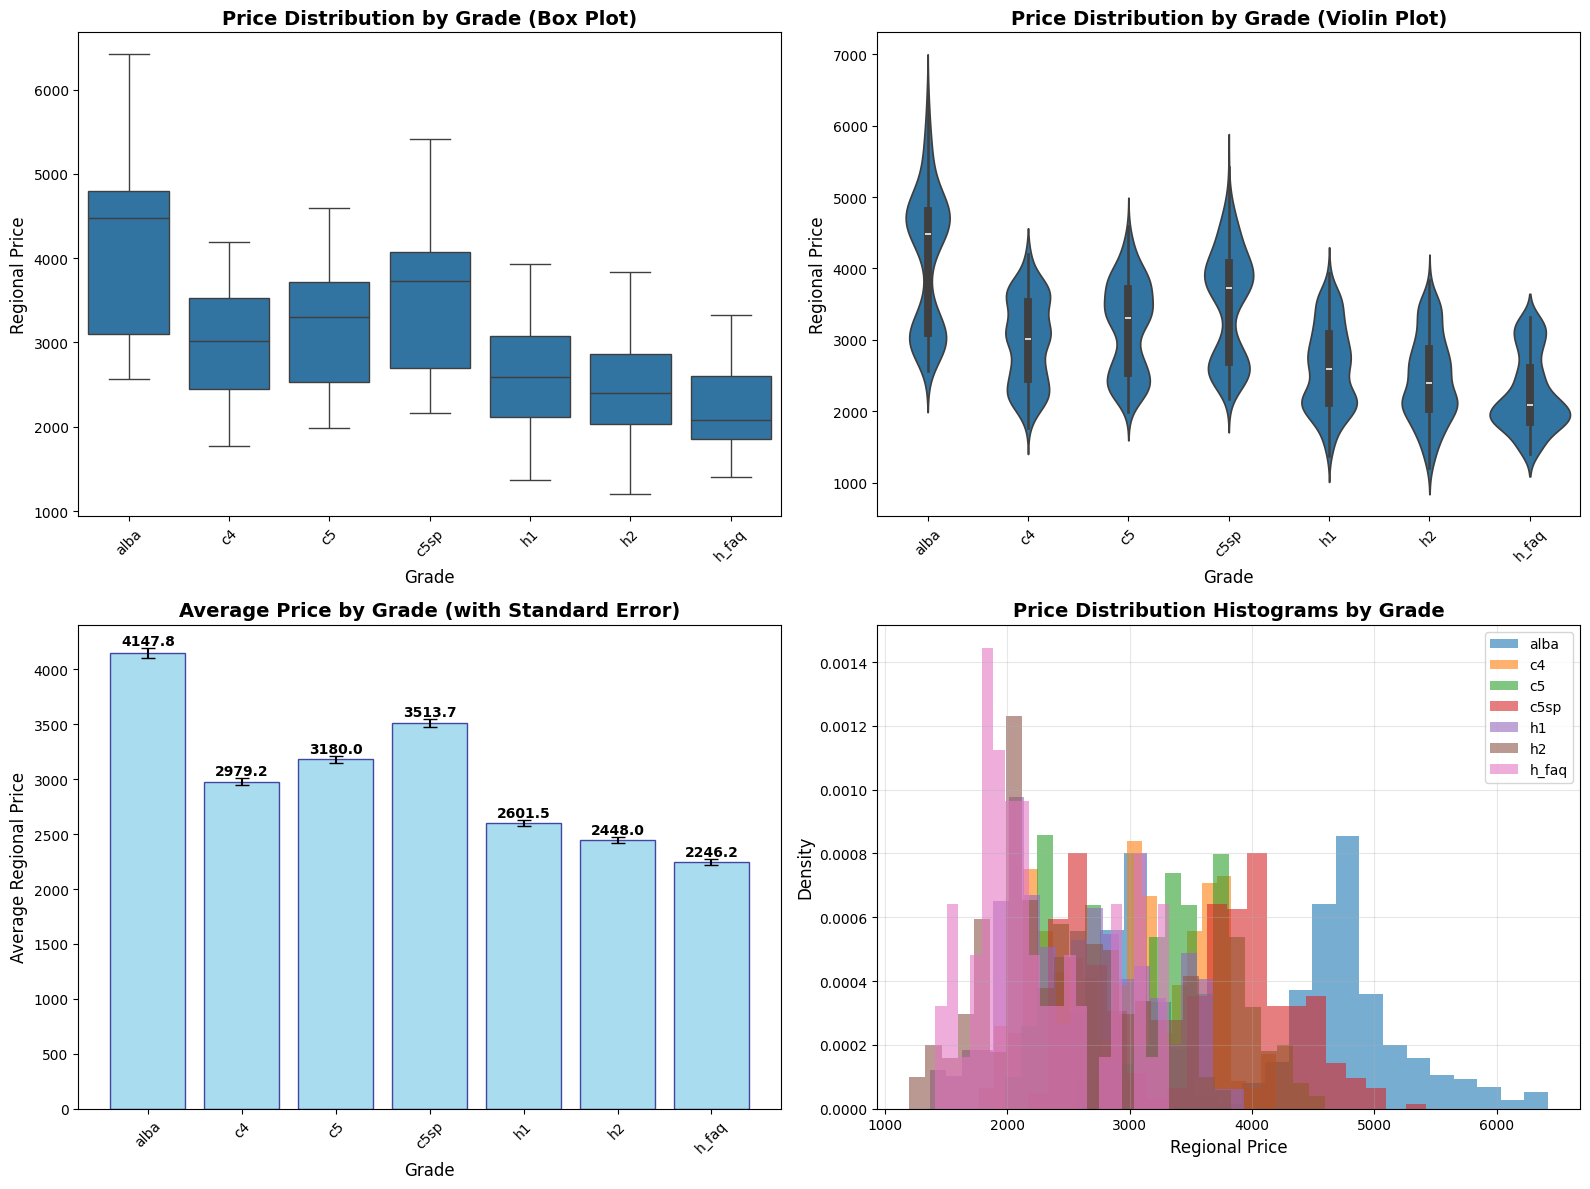


Price Distribution Summary by Grade:
       count     mean     std      min      25%      50%      75%      max
Grade                                                                     
alba   389.0  4147.77  952.13  2566.50  3100.00  4480.00  4800.00  6420.00
c4     383.0  2979.16  598.47  1766.25  2447.62  3016.25  3523.50  4197.00
c5     383.0  3179.96  640.00  1983.00  2533.42  3304.75  3714.60  4600.00
c5sp   383.0  3513.71  757.25  2166.75  2691.75  3725.00  4070.00  5419.80
h1     383.0  2601.51  588.50  1368.75  2114.88  2587.50  3077.00  3937.50
h2     383.0  2447.95  592.97  1199.75  2030.68  2400.00  2867.04  3831.25
h_faq  390.0  2246.17  527.49  1407.50  1855.67  2083.00  2602.50  3324.50


In [6]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6.Visualization Function 2 - Feature Correlation Matrix

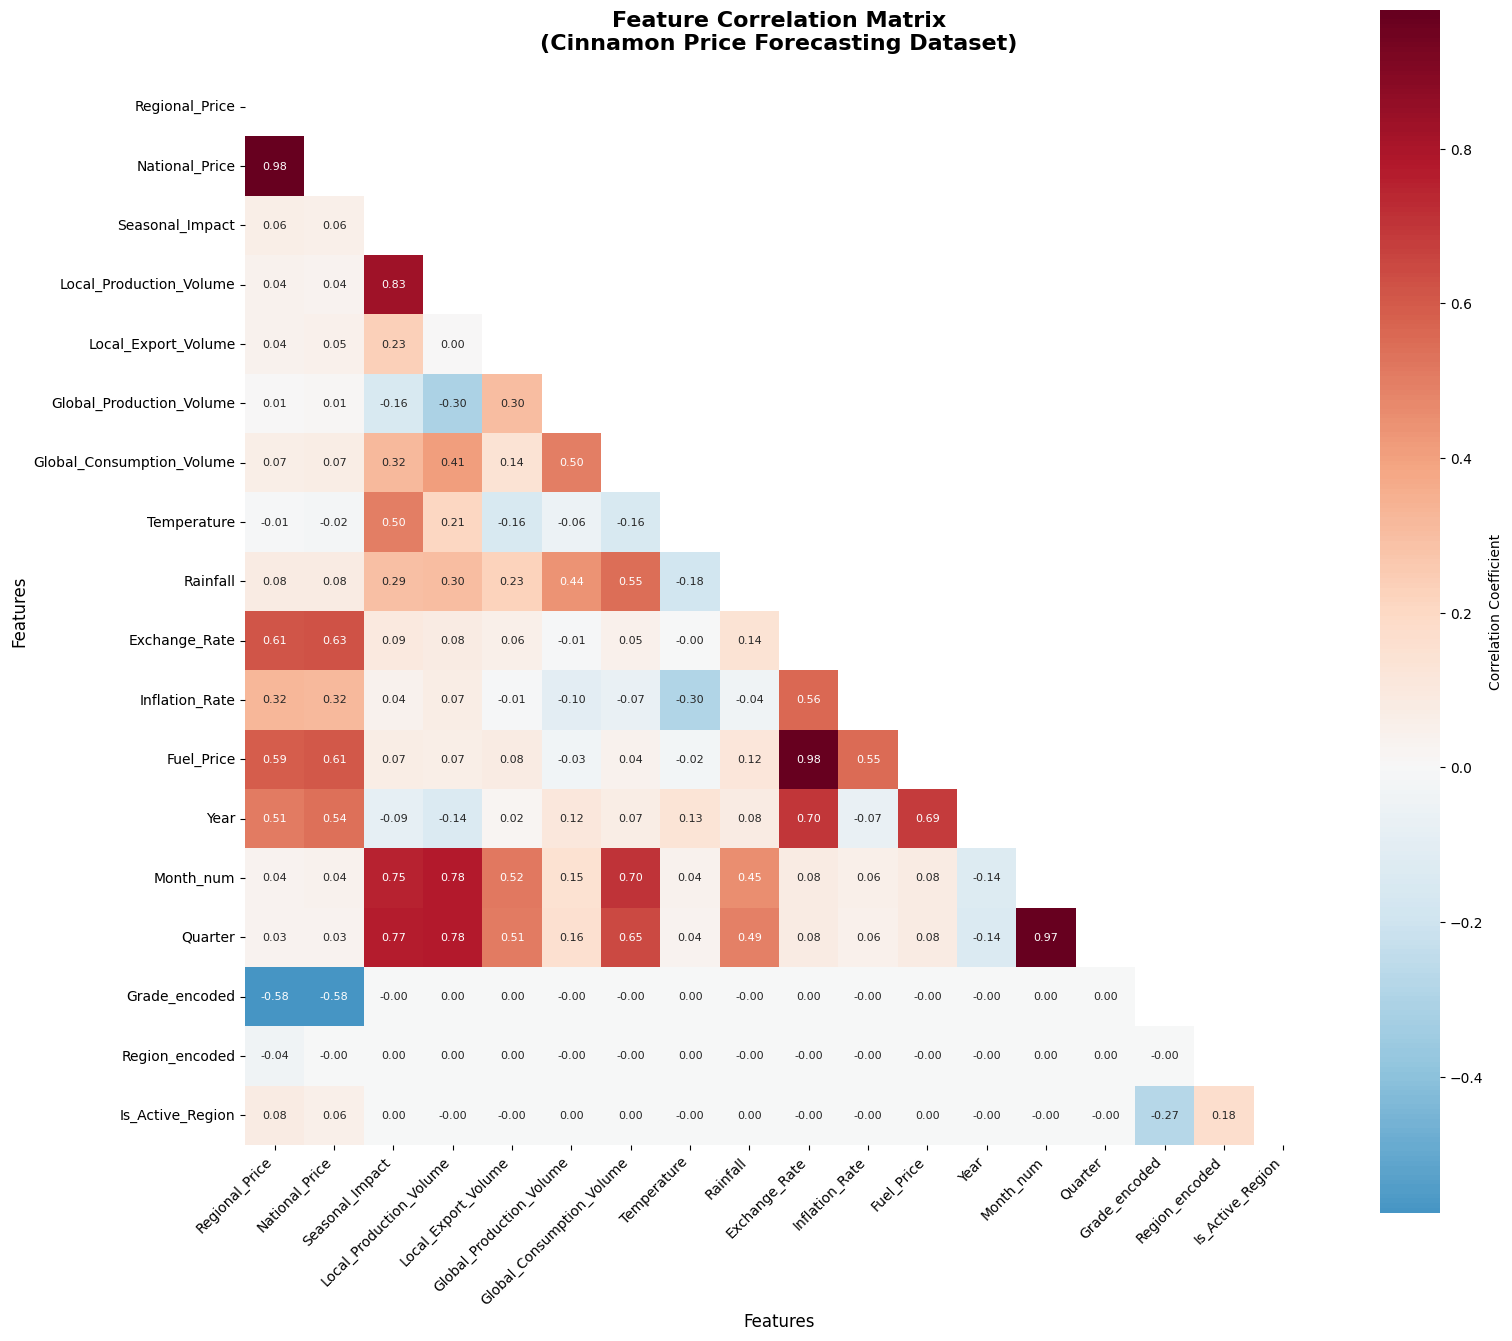


Highly Correlated Feature Pairs (|correlation| > 0.7):
Exchange_Rate ↔ Fuel_Price: 0.980
Regional_Price ↔ National_Price: 0.977
Month_num ↔ Quarter: 0.971
Seasonal_Impact ↔ Local_Production_Volume: 0.832
Local_Production_Volume ↔ Quarter: 0.778
Local_Production_Volume ↔ Month_num: 0.776
Seasonal_Impact ↔ Quarter: 0.773
Seasonal_Impact ↔ Month_num: 0.751
Global_Consumption_Volume ↔ Month_num: 0.704


In [7]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
        'Regional_Price', 'National_Price', 'Seasonal_Impact',
        'Local_Production_Volume', 'Local_Export_Volume',
        'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate',
        'Fuel_Price', 'Year', 'Month_num', 'Quarter', 'Grade_encoded',
        'Region_encoded', 'Is_Active_Region'
    ]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7.Sequence Preparation Function for LSTM

In [8]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Remove rows with NaN values
    df_clean = df.dropna()

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    return np.array(X_sequences), np.array(y_sequences), metadata

# 8. LSTM Model Building Function

In [9]:
def build_lstm_model(input_shape):
    """Build LSTM model"""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 9. Training History Visualization Function

In [10]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 10.Model Training Function

In [11]:
def train_model(df):
    """Train the forecasting model"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    # Build and train model
    print("Building model...")
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    print("Evaluating model...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\nModel Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    return model, history, {'mae': mae, 'rmse': rmse, 'r2': r2}

# 11.Train the Model

Preparing sequences...
Created 897 sequences with shape (897, 12, 42)
Scaling features...
Training set shape: X=(717, 12, 42), y=(717,)
Test set shape: X=(180, 12, 42), y=(180,)
Building model...
Training model...
Epoch 1/100


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2201 - mae: 0.3440 - val_loss: 0.0684 - val_mae: 0.1944 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0759 - mae: 0.2034 - val_loss: 0.0494 - val_mae: 0.1671 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0585 - mae: 0.1818 - val_loss: 0.0393 - val_mae: 0.1461 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0515 - mae: 0.1681 - val_loss: 0.0444 - val_mae: 0.1514 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0498 - mae: 0.1675 - val_loss: 0.0371 - val_mae: 0.1340 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0442 - mae: 0.1549 - val_loss: 0.0486 - val_mae: 0.1647 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0550 - mae: 0.1717 - val_loss: 0.0474 - val_mae: 0.1500 - learning_rate: 0.0010
Epoch 8/100
18/18 

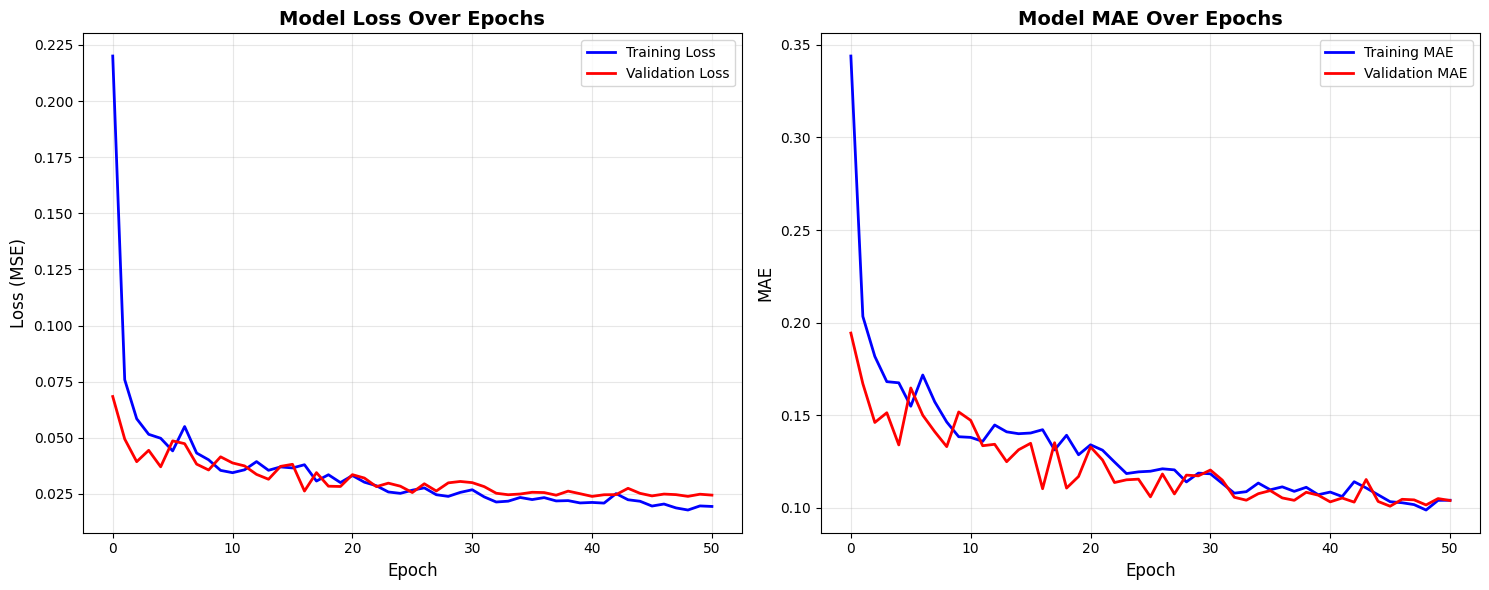


Final Training Metrics:
Training Loss: 0.0194
Validation Loss: 0.0244
Training MAE: 0.1041
Validation MAE: 0.1040
Evaluating model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Model Performance:
MAE: 89.37
RMSE: 131.93
R²: 0.9757

Model training completed!


In [12]:
model, history, metrics = train_model(df)
print("\nModel training completed!")

# 12.Save the Model

In [13]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"cinnamon_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2'])
            }
        }
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")


📁 Saving model to: cinnamon_models\cinnamon_model_20250902_162755
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: cinnamon_models\cinnamon_model_20250902_162755
Model saved at: cinnamon_models\cinnamon_model_20250902_162755


# 13. Forecasting Functions

In [14]:
def forecast_prices(model, df, grade, region, months_ahead=12):
    """Generate price forecasts"""
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')

    if len(subset) < SEQUENCE_LENGTH:
        raise ValueError(f"Not enough historical data for {grade}-{region}")

    base_feature_cols = [
        'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')

    future_rows = []
    for i, future_date in enumerate(future_dates):
        future_row = last_row.copy()
        future_row['Month'] = future_date
        future_row['Year'] = future_date.year
        future_row['Month_num'] = future_date.month
        future_row['Quarter'] = future_date.quarter

        # Adjust key features with seasonal patterns
        base_temp = last_row['Temperature']
        seasonal_temp_adj = 2 * np.sin(2 * np.pi * (future_date.month - 1) / 12)
        future_row['Temperature'] = base_temp + seasonal_temp_adj + np.random.normal(0, 0.5)

        base_rainfall = last_row['Rainfall']
        seasonal_rain_adj = 20 * np.sin(2 * np.pi * (future_date.month - 1) / 12)
        future_row['Rainfall'] = max(0, base_rainfall + seasonal_rain_adj + np.random.normal(0, 10))

        future_row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001, 0.005))
        future_row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0, 0.1)
        future_row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002, 0.02))

        future_rows.append(future_row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag/rolling features
    extended_df = extended_df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in extended_df.columns:
            for lag in [1, 3, 6, 12]:
                extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade', 'Region'])[col].shift(lag)

    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in extended_df.columns:
            for window in [3, 6, 12]:
                extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    feature_cols = base_feature_cols.copy()
    lag_cols = [col for col in extended_df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)
    feature_cols = [col for col in feature_cols if col in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data) - SEQUENCE_LENGTH + i:len(historical_data) + i]

        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known] * padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data) + i
        if future_idx < len(extended_df):
            extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
            extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates

# 14. Forecast Visulaization Function

In [15]:
def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot 2: Historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Customize the plot
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR.{price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR.{np.mean(forecasts):.2f}")
        print(f"Price Range: LKR.{np.min(forecasts):.2f} - LKR.{np.max(forecasts):.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR.{abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 15.Generate Forecast Visualizations

Available grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Available regions: ['colombo' 'galle' 'hambantota' 'kalutara' 'matara' 'ratnapura']

📈 Generating forecast for alba in colombo...


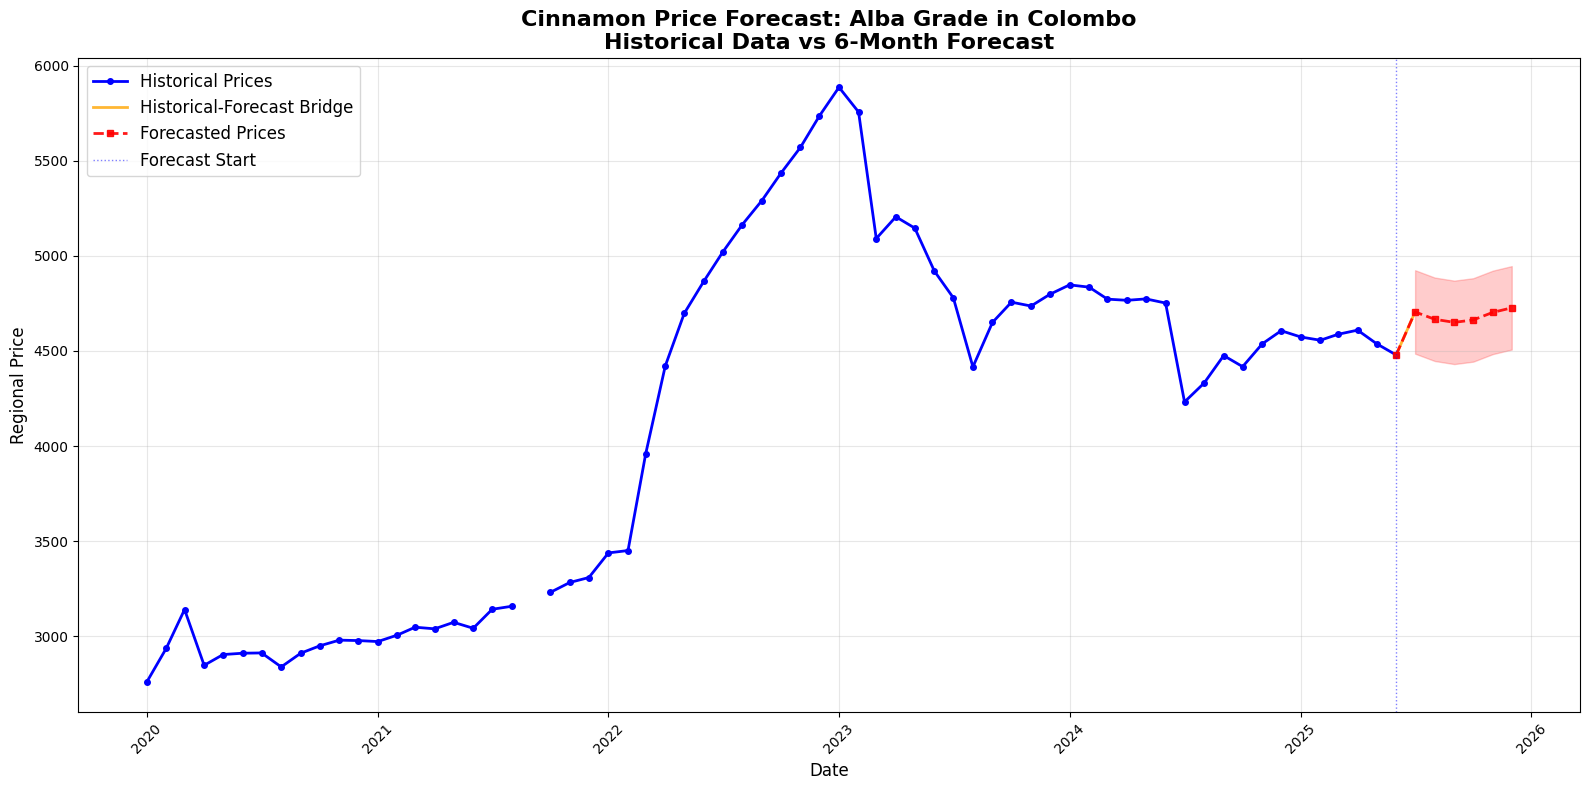


Alba Grade Forecast for Colombo:
Month  1 (2025-07): LKR. 4704.73
Month  2 (2025-08): LKR. 4666.20
Month  3 (2025-09): LKR. 4649.92
Month  4 (2025-10): LKR. 4662.71
Month  5 (2025-11): LKR. 4702.38
Month  6 (2025-12): LKR. 4726.32

Forecast Statistics:
Average Forecast Price: LKR.4685.38
Price Range: LKR.4649.92 - LKR.4726.32
Overall Trend: increasing by LKR.3.60 per month

📈 Generating forecast for c4 in galle...


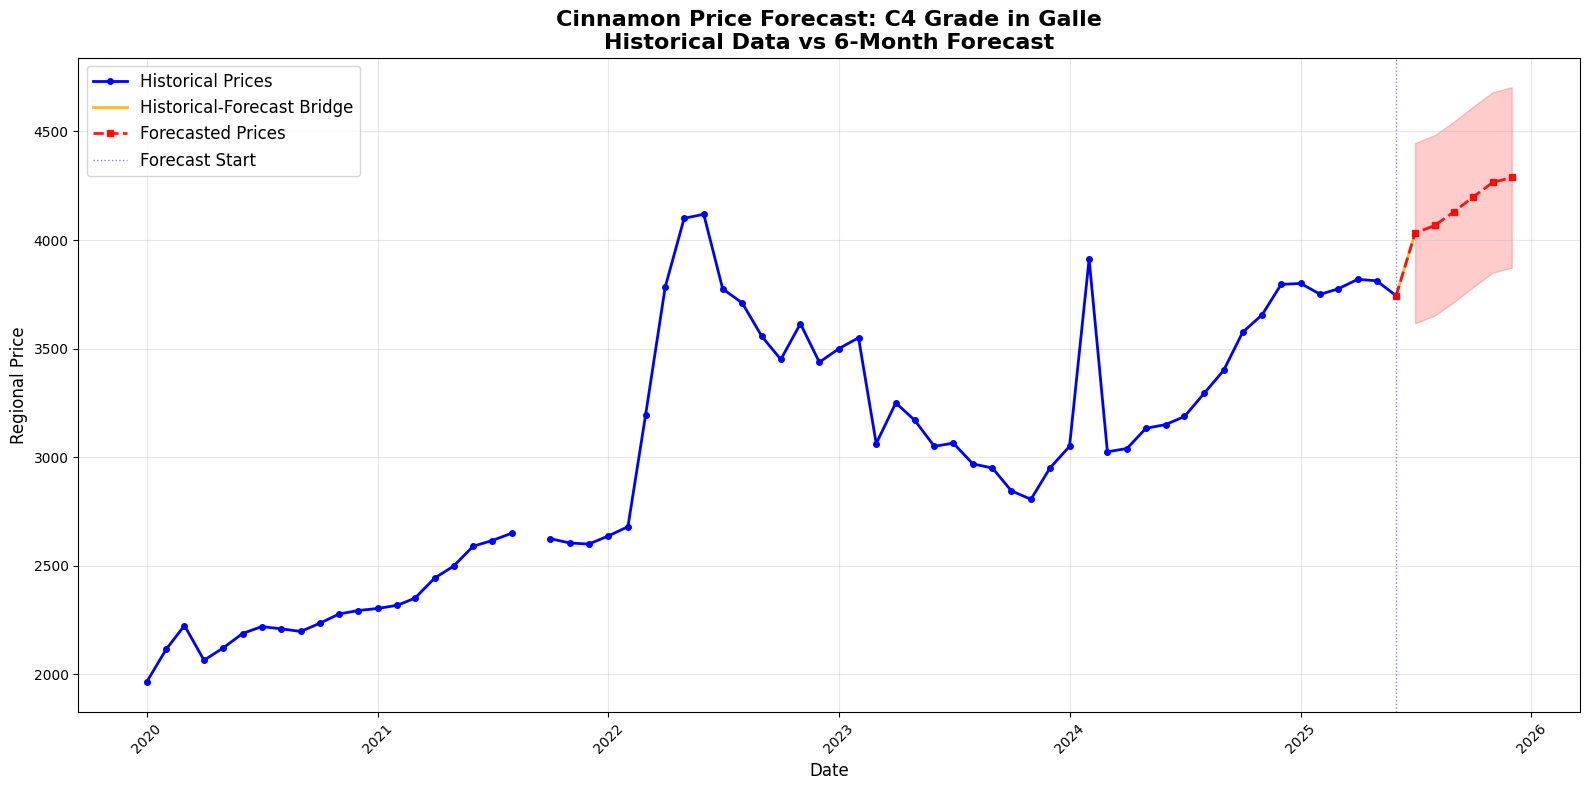


C4 Grade Forecast for Galle:
Month  1 (2025-07): LKR. 4031.81
Month  2 (2025-08): LKR. 4067.27
Month  3 (2025-09): LKR. 4130.91
Month  4 (2025-10): LKR. 4198.69
Month  5 (2025-11): LKR. 4265.53
Month  6 (2025-12): LKR. 4287.94

Forecast Statistics:
Average Forecast Price: LKR.4163.69
Price Range: LKR.4031.81 - LKR.4287.94
Overall Trend: increasing by LKR.42.69 per month


In [16]:
available_grades = df['Grade'].unique()
available_regions = df['Region'].unique()

print(f"Available grades: {available_grades}")
print(f"Available regions: {available_regions}")

# Generate forecast for first combination
if len(available_grades) > 0 and len(available_regions) > 0:
    grade_to_forecast = available_grades[0]
    region_to_forecast = available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast} in {region_to_forecast}...")
    forecasts1, future_dates1 = plot_forecast_results(
        df, model, grade_to_forecast, region_to_forecast, months_ahead=6
    )

# Try another combination if available
if len(available_grades) > 1 and len(available_regions) > 1:
    grade_to_forecast2 = available_grades[1] if len(available_grades) > 1 else available_grades[0]
    region_to_forecast2 = available_regions[1] if len(available_regions) > 1 else available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast2} in {region_to_forecast2}...")
    forecasts2, future_dates2 = plot_forecast_results(
        df, model, grade_to_forecast2, region_to_forecast2, months_ahead=6
    )

# 16. Interactive Forecast Generation


🔮 Interactive Forecast Generation

Available Grades:
1. alba
2. c4
3. c5
4. c5sp
5. h1
6. h2
7. h_faq

Available Regions:
1. colombo
2. galle
3. hambantota
4. kalutara
5. matara
6. ratnapura

📊 Generating 6-month forecast for alba in galle...


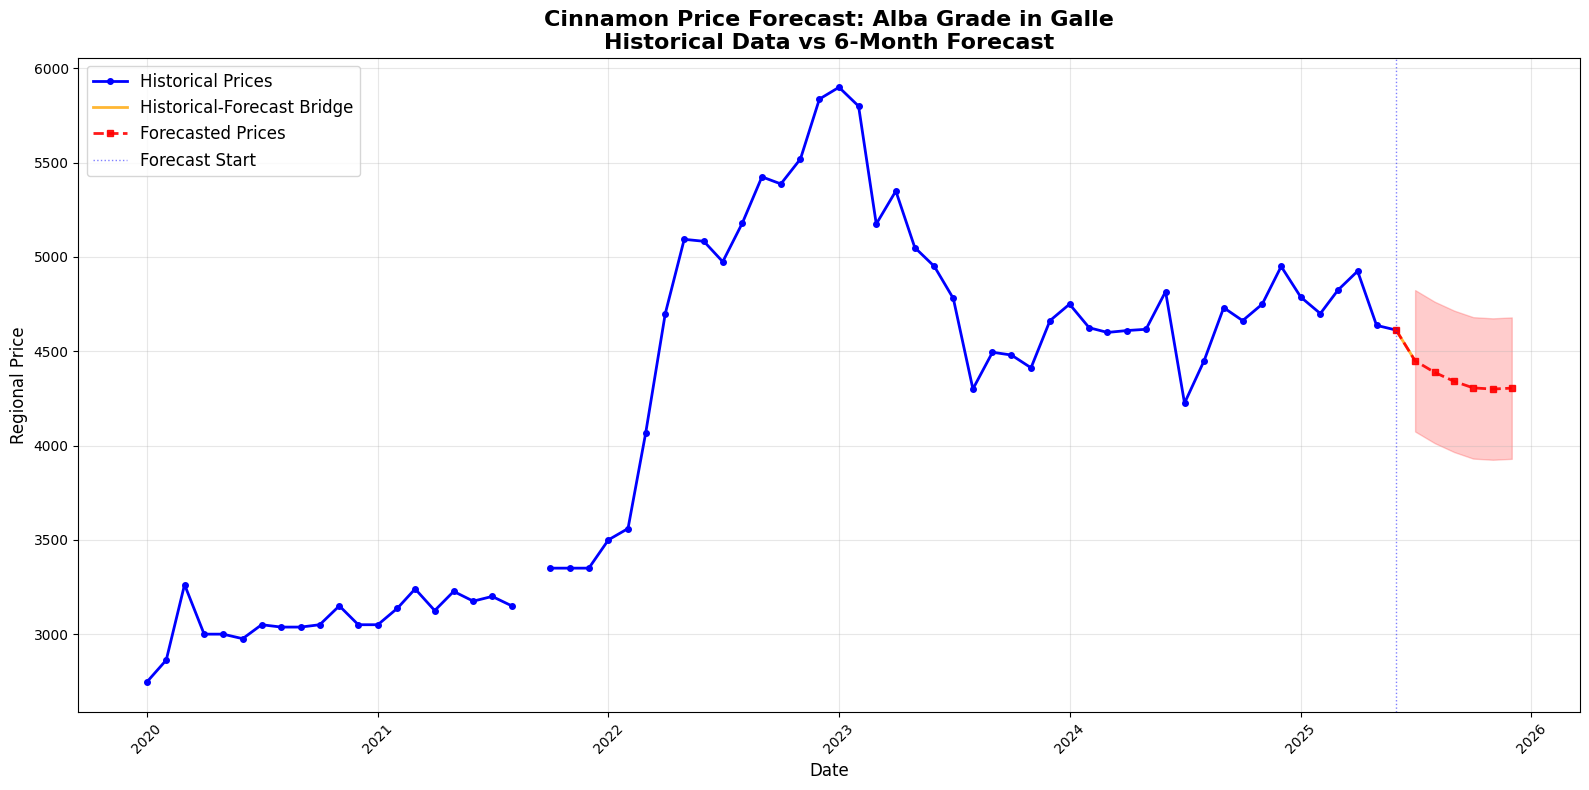


Alba Grade Forecast for Galle:
Month  1 (2025-07): LKR. 4449.62
Month  2 (2025-08): LKR. 4387.88
Month  3 (2025-09): LKR. 4340.37
Month  4 (2025-10): LKR. 4305.92
Month  5 (2025-11): LKR. 4299.72
Month  6 (2025-12): LKR. 4304.62

Forecast Statistics:
Average Forecast Price: LKR.4348.02
Price Range: LKR.4299.72 - LKR.4449.62
Overall Trend: decreasing by LKR.24.17 per month


([np.float32(4449.6157),
  np.float32(4387.883),
  np.float32(4340.3677),
  np.float32(4305.9155),
  np.float32(4299.722),
  np.float32(4304.6177)],
 DatetimeIndex(['2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
                '2025-11-01', '2025-12-01'],
               dtype='datetime64[ns]', freq='MS'))

In [23]:
def interactive_forecast():
    """Allow user to select grade and region for forecasting"""
    print("\n🔮 Interactive Forecast Generation")
    print("=" * 50)
    
    # Display available options
    print("\nAvailable Grades:")
    for i, grade in enumerate(available_grades, 1):
        print(f"{i}. {grade}")
    
    print("\nAvailable Regions:")
    for i, region in enumerate(available_regions, 1):
        print(f"{i}. {region}")
    
    # Get user input
    try:
        grade_idx = int(input("\nSelect grade number: ")) - 1
        region_idx = int(input("Select region number: ")) - 1
        months = int(input("How many months to forecast (default 12): ") or "12")
        
        if 0 <= grade_idx < len(available_grades) and 0 <= region_idx < len(available_regions):
            selected_grade = available_grades[grade_idx]
            selected_region = available_regions[region_idx]
            
            print(f"\n📊 Generating {months}-month forecast for {selected_grade} in {selected_region}...")
            forecasts, dates = plot_forecast_results(
                df, model, selected_grade, selected_region, months_ahead=months
            )
            return forecasts, dates
        else:
            print("Invalid selection. Please try again.")
            return None, None
            
    except (ValueError, IndexError) as e:
        print(f"Error: {e}. Please enter valid numbers.")
        return None, None

# Uncomment to run interactive forecast
interactive_forecast()

# 17.Load Existing Model

In [18]:
def list_saved_models(model_dir=MODEL_DIR):
    """List all saved model directories in the model directory"""
    if not os.path.exists(model_dir):
        return []
    # Only include directories that look like saved models
    return [
        os.path.join(model_dir, d)
        for d in os.listdir(model_dir)
        if os.path.isdir(os.path.join(model_dir, d)) and d.startswith("cinnamon_model_")
    ]

def load_existing_model():
    """Load a previously saved model"""
    existing_models = list_saved_models()
    
    if not existing_models:
        print("No saved models found. Please train a model first.")
        return None, None
    
    print("\nSelect a model to load:")
    for i, model_path in enumerate(existing_models, 1):
        print(f"{i}. {os.path.basename(model_path)}")
    
    try:
        choice = int(input("\nEnter model number: ")) - 1
        if 0 <= choice < len(existing_models):
            selected_model_path = existing_models[choice]
            loaded_model, config = load_saved_model(selected_model_path)
            return loaded_model, config
        else:
            print("Invalid choice.")
            return None, None
    except (ValueError, IndexError):
        print("Invalid input.")
        return None, None

loaded_model, loaded_config = load_existing_model()
if loaded_model:
    model = loaded_model  # Replace current model with loaded one


Select a model to load:
1. cinnamon_model_20250902_122247
2. cinnamon_model_20250902_130742
3. cinnamon_model_20250902_131404
4. cinnamon_model_20250902_145559
5. cinnamon_model_20250902_162755
📂 Loading model from: cinnamon_models\cinnamon_model_20250902_122247
✅ Keras model loaded
✅ Scalers loaded
✅ Label encoders loaded
🎉 Model successfully loaded!
📊 Performance: MAE=114.08, RMSE=161.86, R²=0.9634


# 18. Model Performance Comparison

Evaluating model performance...
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


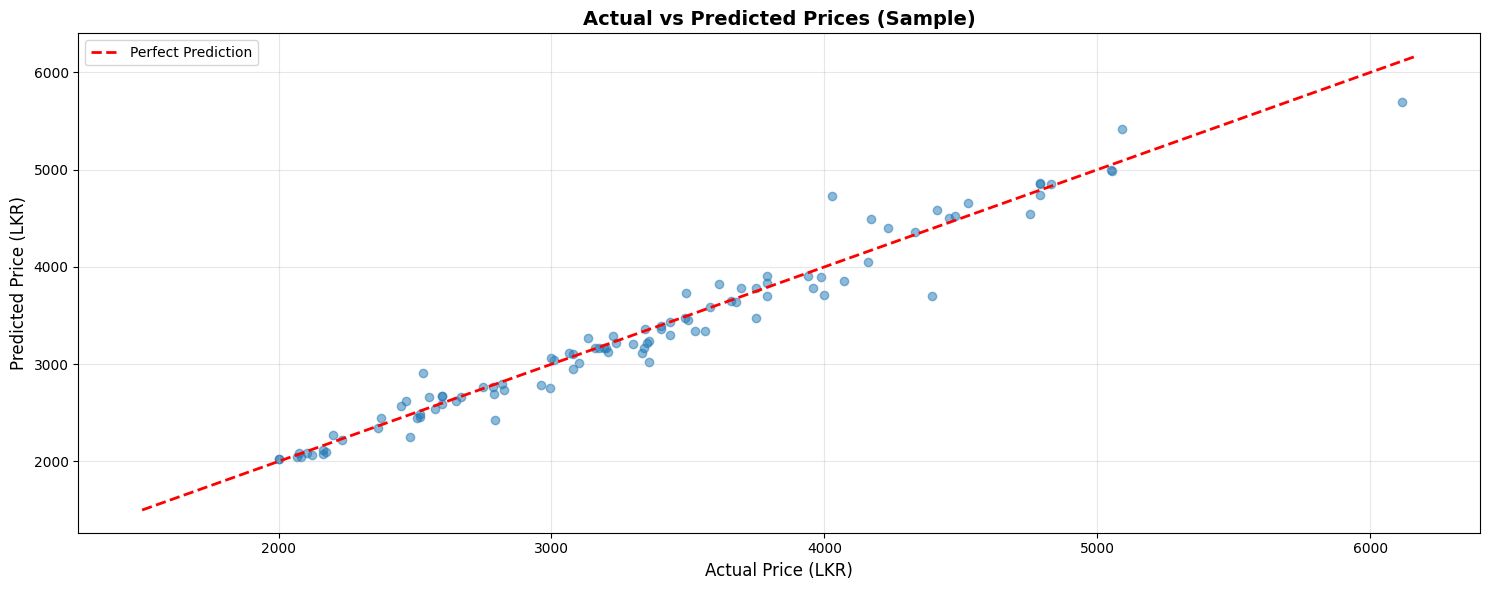


Overall Model Performance:
MAE: 100.63
RMSE: 143.81
R²: 0.9721


In [19]:
def evaluate_model_performance(model, df):
    """Evaluate model performance on test data"""
    print("Evaluating model performance...")
    
    # Prepare sequences again for evaluation
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)
    
    # Scale features
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)
    
    # Make predictions
    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    
    # Create comparison plot
    plt.figure(figsize=(15, 6))
    
    # Sample 100 random predictions for visualization
    sample_size = min(100, len(y))
    indices = np.random.choice(len(y), sample_size, replace=False)
    
    plt.scatter(y[indices], y_pred[indices], alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Price (LKR)', fontsize=12)
    plt.ylabel('Predicted Price (LKR)', fontsize=12)
    plt.title('Actual vs Predicted Prices (Sample)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    print(f"\nOverall Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# Evaluate the model
performance_metrics = evaluate_model_performance(model, df)